# Unexpected Characteristics of NYC Neighborhoods
---

## Introduction

New York City, being the very compact melting pot that it is, exhibits clearcut patterns of spatial segregation both 'officially', such as districts types and zoning regulations, and 'unofficially', such as the groupings of members of a similar culture or part of the world. These spatial partitions are uniquely characterized by the activity and physical structures within them, but there is yet another category of traits that often reveals itself more clearly to tourists than New Yorkers, and that is the generally low level of hygeiene and maintenence. Not to say that this is unorthodox, only that many of these poor conditions are prominent where they are not expected to be present. 

Out of the many variables that define 'bad' conditions and 'good' neighborhoods, the ones chosen to be explored together were done so as a result of observational experience. Neighborhoods with more accessability to parks/open spaces, train stations, and farmers' markets can be considered nicer, however, all of which are also associated with higher trash output  and/or heavier rodent activity. Another trait of a better neighborhood is having high property values, and in NYC, many of those include buildings that are much less modern than it may seem from the environment surrounding them. Sometimes the deterioration of aging is more subtle to the public, other times, the consequences of the primitive infrastrcutre calls for constant care, such as sewege odors/overflows or broken up streets. Furthermore, street homelessness is seemingly more prevalent in places where there is a perceived chance of higher earning potential.  

In the case of NYC, is the very reason poor qualities are present in nicer neighborhoods the same reason they were initially unexpected. So, do some of the most affluent neighborhoods in NYC possess the most undesirable traits as a result of the same activities that contribute to their affluence?

## Data  

__Scale:__ Neighborhood Tabulation Areas (NTA)  

__Variables to depict affluent neighborhoods:  __
- High property values  
- Within walking distance from public transportation, parks and open spaces  
- The presence of an accessable farmers' markets 

__Variables to depict undesirable traits:  __
- Presence of rodents  
- Prevalence of homelessness  
- Seweage / infrastructure damage  
- Trash / dirty streets 

| Variable | Data Source | Format | URL |  
|---|---|---|---|
|Rodents, Homelessness, Seweage, and Dirty conditions | Filtered 311 service requests (_311_) | CSV | [NYC Open Data](https://data.cityofnewyork.us/Social-Services/311-Service-Requests/fvrb-kbbt)|  
|Property values | Dept of Finance (_DOF_) | CSV | [NYC Open Data](https://data.cityofnewyork.us/City-Government/Revised-Notice-of-Property-Value-RNOPV-/8vgb-zm6e)|
|Farmers' markets | Dept of Health and Mental Hygiene (_DOHMH_) | CSV | [NYC Open Data](https://data.cityofnewyork.us/Health/New-York-City-Farmers-Markets/j8gx-kc43)|  
|Parks properties | Dept of Parks and Recreation (_DPR_) | GeoJSON | [NYC Open Data](https://data.cityofnewyork.us/Transportation/Subway-Entrances/drex-xx56)|
|Subway entrances | Metropolitan Transportation Authority (_MTA_) | GeoJSON | [NYC Open Data](https://data.cityofnewyork.us/City-Government/Parks-Properties/rjaj-zgq7)|  
|Neighborhood Tabulation Areas (NTA) | Dept of City Planning (_DCP_) | GeoJSON | [NYC Open Data](https://data.cityofnewyork.us/City-Government/Census-Demographics-at-the-Neighborhood-Tabulation/rnsn-acs2)|

## Methods

### Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pysal as ps
from pysal.esda import mapclassify

% matplotlib inline

### Reading data

In [2]:
def ReadGeoJSON(url):
    """Reads http request for GeoJSON file. 
    Parameters: download url string
    Returns: geopandas GeoDataFrame of GeoJSON
    """
    import geopandas as gpd
    import requests
    
    data_url = url
    data = requests.get(data_url)
    data_gdf = gpd.GeoDataFrame.from_features(data.json(),crs="+init=epsg:4326")
    data_gdf = data_gdf.to_crs("+init=epsg:2263")
    return (data_gdf)

In [3]:
def ReadCSV(filename):
    """Reads csv file from directory. 
    Parameters: csv filename
    Returns: pandas DataFrame of file
    """
    import pandas as pd
    
    df = pd.read_csv(filename,low_memory=False)
    return df

### Filters

Data cleaning of CSV files was consistent of running each one through a set of filters.

The first filter is to ___query___ categorical refinement, the second to validate ___location___ information, and the third to extract only ___recent___ records (2017 and later).   

In [4]:
def Query(df, con_col, con):
    """ Filters a DataFrame based on the values in the column passed
    Parameters: df - pandas DataFrame to filter
                con_col - the column to filter based on conditional
                con - list of desired values in new dataframe
    Returns: new DataFrame with excluded rows 
    """
    
    if type(con) is list:
        new_df = df.loc[df[con_col].isin(con)]   
    else: 
        new_df = df.loc[df[con_col] != con]
    return new_df

In [5]:
def NullLat(df, lat_col='Latitude'):
    """ Filters DataFrame for valid Lat/Lon values
    Parameters: df - pandas DataFrame to filter
                lat_col - column name of latitude data, default='Latitude'
    Returns: new DataFrame without null latitude rows    
    """
    
    new_df = df.dropna(subset=[lat_col])
    return new_df

In [6]:
def FilterDate(df, date_col):
    """ Creates datetime object from date date_column in DataFrame
    Parameters: df - pandas DataFrame to filter
                date_date_col - date_column name of date objects
    Returns: new DataFrame with recent dates (2017 and later) as string
    """
    
    new_df = df.copy()
    new_df[date_col] = pd.to_datetime(new_df[date_col]) 
    new_df = new_df.loc[new_df[date_col].dt.year > 2016]         
    new_df[date_col] = new_df[date_col].astype(str)
    return(new_df)

### Geometries

For all tabular data, ___point___ features were created using the provided latitude/longitude fields with the exception of farmers' markets, whose points were created by ___geocoding___ a derived address field.

In [7]:
def PointGeom(df, lon_col='Longitude', lat_col='Latitude'):
    """ Creates point geometries from lat/lon columns in df. 
    Parameters: df - pandas DataFrame with lat/lon columns
                lat_col - lat column name
                lon_col - lon column name
    Returns: new geopandas GeoDataFrame with crs: epsg=2263 
    """
    from shapely.geometry import Point
    
    geom = [Point (x,y) for x,y in zip(df[lon_col], df[lat_col])]
    wgs = "+init=epsg:4326"
    new_gdf = gpd.GeoDataFrame(df, crs=wgs, geometry=geom)
    new_gdf = new_gdf.to_crs("+init=epsg:2263")
    
    return new_gdf

In [8]:
def GetKey(file, key_num=-1):
    """
    Retrieves one Google geocoding API key from text file
    Parameters: path - full path with filename of text file
                ix - index vaue of key to return, default is last key
    Returns: API key as string
    """

    with open(file) as k:
        keys = k.readlines()
    key = keys[key_num].strip('\n')
    return(key)

def Geocode(df, addr_col, keys_file='GoogleAPIkey.txt', key_ix=-1):
    """ Iterate over the rows of a dataframe and geocode records on each iteration. 
    Parameters: df - dataframe with column containing address or location info 
                addr_col - name of the column with the full address info 
                keys_file - filename with Google API Geocode key,
                            default is 'GoogleAPIkey.txt'
                key_ix - the line number of they key to be used, 
                        default is the last line
    Returns: DataFrame of indices and lat/lon columns
    """

    from geopandas.tools import geocode
    from geopy.geocoders import GoogleV3
    import time

    
    lats = []
    lons = []
    inx = []
    counter = 0
    key = GetKey(keys_file, key_num=key_ix)
    g = GoogleV3(api_key=key, timeout=10)
    
    for ix, row in df[addr_col].iteritems():
        if counter%50==0:
            time.sleep(1)
        counter =+1
        try:
            location = g.geocode(row)
            lats.append(location.latitude)
            lons.append(location.longitude)
            inx.append(ix)
        
        except Exception as e:
            continue
    
    new_df = pd.DataFrame({'lat':lats, 'lon':lons}, index=inx)
    return new_df

Each point feature was then ___spatially join___ to NTA polygons. 

In [9]:
def SpatialJoin(poly_gdf, point_gdf):
    """ Left spatial join points to polygons
    Parameters: poly_gdf - polygon GeoDataFrame
                point_gdf - point GeoDataFrame
    Returns: New GeoDataFrame of polygons with point attributes
    """
    
    new_gdf = gpd.sjoin(poly_gdf, point_gdf, how='left')
    return new_gdf

### Densities

The ___density___ of 311 service requests was found by counting point within each NTA, while for property values it was the averaged market value, then normalized by the NTA's area (in km2).

In [10]:
def PointDensity(count_gdf, nta_gdf, col_prfx):    
    """ Finds counts and density (km2) within NTA 
    Parameters: nta_gdf - GeoDataFrame of values and area
                col_prfx - name prefix for count and density columns
    Returns: NTA GeoDataFrame with new count and density columns
    """
    
    count_col = gpd.GeoSeries(count_gdf.groupby('NTACode')['Unique Key'].count())
    count_col.name = col_prfx + 'Count'
    nta_dens = nta_gdf.join(count_col, on='NTACode', how='left')
    nta_dens[col_prfx+'Dens'] = nta_dens[col_prfx+'Count']/(nta_gdf.geometry.area*0.00000009290304)

    return nta_dens

___Buffers___ of 600 ft, 1000 ft, and 1,500 ft were created for subway entrances, parks/open spaces, and farmers' markets respectively, then ___dissolved___ and ___overlain___ onto NTA polygons.

> Note that the overlay function writes an intermediate shapefile to the present working directory.  

In [11]:
def Buffer(gdf, dist):
    """ Create buffer 
    Parameters: gdf -  GeoDataFrame to buffer
                dist - distance in feet
    Returns: GeoSeries with '(dist)Bfr' column name 
    """
    
    bfr_gs = gdf.buffer(dist)
    bfr_gs.name = str(dist)+'Bfr'
    
    return bfr_gs

In [12]:
def DissolveBuffer(nta_gdf, bfr):
    """
    Dissolve buffer in boroughs 
    Parameters: nta_gdf - dissolved nta GeoDataFrame
                bfr - buffer GeoSeries
    Returns: Buffer GeoDataFrame
    """
    
    unun = bfr.cascaded_union
    intrsct = nta_gdf.intersection(unun)
    intrsct.name = 'geometry'
    intrsct_gs = intrsct.loc[intrsct.is_empty == False]

    bfr_gdf = gpd.GeoDataFrame(intrsct_gs, geometry='geometry')
    bfr_gdf.crs = nta_gdf.crs
    
    return(bfr_gdf)

In [13]:
def Ovr(gdf_1, gdf_2, how, new_filename):
    """ Overlays two GeoDataFrames and write resulting file
    Parameters: gdf_1 - geometry gdf 
                gdf_2 - join gdf
                how - overlay method
                new_filename - new filename to save overlay
    Returns: Projected and saved new file.
    """
    
    new_gdf = gpd.overlay(gdf_1, gdf_2, how=how) 
    new_gdf.crs = gdf_1.crs
    new_gdf.to_file(new_filename)

    return new_gdf

The ___total area___ of the buffers and ___average property values___ in each NTA was found.

In [14]:
def NTADcts(nta_gdf, bfr_ovr):
    """ Finds buffer area within NTA area
    Parameters: nta_gdf - NTA GeoDataFrame
                bfr_gdf - buffer GeoDataFrame
    Returns: buffer densities as NTA dictionary values
    """
    
    bfr_ovr.dropna(subset=['NTACode'], inplace=True)
    nta_dct = {}
    
    for ntacode in bfr_ovr.NTACode.tolist():
        nta_area = nta_gdf.loc[nta_gdf.NTACode == ntacode].area.values.sum()
        bfr_area = bfr_ovr.loc[bfr_ovr.NTACode == ntacode].area.values.sum()
        bfr_dens = float(bfr_area/nta_area)
        nta_dct[ntacode] = bfr_dens

    return nta_dct

In [15]:
def RNOPVDcts(nta_gdf, rnopv):
    """ Finds property values for NTA
    Parameters: nta_gdf - nta GeoDataFrame
                rnopv - rnopv file
    Returns: dictionary of average property  values by area
    """
    
    nta_codes = rnopv.NTACode.unique().tolist()
    rnopv_dct = {}
    
    for code in nta_codes:
        nta_area = float(nta_gdf.loc[nta_gdf.NTACode == code].area.values)
        nta_rnopv = rnopv.loc[rnopv.NTACode == code]
        nta_vals = nta_rnopv['REVISED MARKET VALUE'].values.tolist()
        rnopv_dct[code] = (sum(nta_vals)/len(nta_vals))/nta_area
        
    return rnopv_dct

The ___buffer density___ was derived from the fraction of each buffer's area that fell within an NTA and represents the level of accessability of an NTA to the buffered feature.   

In [16]:
def BufferDensity(nta_gdf, nta_dct, col_name):
    """ Find how much of buffer falls within the NTA
    Parameters: nta_gdf - NTA GeoDataFrame
                nta_dct - dictionary of NTA buffers
                col_name - new column name 
    Returns: new NTA GeoDataFrames with density columns
    """
    
    bfr_dens_df = pd.DataFrame.from_dict(nta_dct,'index')
    bfr_dens_df.columns = [col_name]
    bfr_dens_df.index.name = 'NTACode'

    fillna_col = bfr_dens_df.columns.tolist().pop()
    nta_dens = nta_gdf.join(bfr_dens_df, on='NTACode', how='left')
    nta_dens[fillna_col].fillna(0, inplace=True)
    
    return nta_dens

### Weights

Thresholds were based on the best (or close second) ___classification___ method determined by a Goodness of Absolute Deviation Fitness (gadf) measure applied to each variable's density values using `pysal.esda.mapclassify.K_classifiers.results` and `pysal.esda.mapclassify.gadf`.   

_Luckily_, all data agreed with being broken up into 6 classes using Fisher-Jenks.  

Each class was then assigned a value, or ___weight___, from 1 to 6. This was done in ascending order for 'good' featuers and descending for 'bad' ones. 

This made it such that lower weights were indicative of poor conditions/bad neighborhoods and higher weights of good conditions/nice neighborhoods. 

In [17]:
def ApplyWeights(dens_gdf,bd='gd'):
    """ Give weights to each class
    Parameters: dens_gdf - DataFrame with density values to classify
                bd - if 'bd', weights are applied in classes with 
                    descending order, default is 'gd' (ascending order)
    Returns: DataFrame with weights according to classes
    """
        
    dens_col = [col for col in dens_gdf.columns.tolist() if 'Den' in col].pop()
    bins_list = mapclassify.Fisher_Jenks(dens_gdf[dens_col], k=6).bins.tolist()
    bins_list.insert(0,0)
    wght_dct = {}
    wght = 1

    if bd == 'bd':
        bins_list = bins_list[::-1]
    for i in range(len(bins_list)-1):
        if bd == 'bd':
            mini = bins_list[i+1]
            maxi = bins_list[i]
        else:
            mini = bins_list[i]
            maxi = bins_list[i+1]
        bins_gdf = dens_gdf.loc[(dens_gdf[dens_col] >= mini) & (dens_gdf[dens_col] <= maxi)]  
        nta_wght = bins_gdf.NTACode.tolist()

        for nta in nta_wght:
            wght_dct[nta] = float(dens_gdf[dens_col].loc[dens_gdf.NTACode == nta]), wght
        wght += 1

    wght_df = pd.DataFrame.from_dict(wght_dct,'index')
    col_prfx = dens_col[:3]
    wght_df.columns = col_prfx + 'Dens', col_prfx + 'Wght'
    wght_df.index.name = 'NTACode'
    
    return wght_df

### Applying it to the Data 

#### NTA

In [18]:
nta = ReadGeoJSON('http://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/nynta/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=geojson')

#### Subway  

In [19]:
mta_stops = ReadGeoJSON('https://data.cityofnewyork.us/api/geospatial/drex-xx56?method=export&format=GeoJSON')
mta_bfr = Buffer(mta_stops, 1000)
mta_dslv = DissolveBuffer (nta, mta_bfr)
mta_nta = Ovr (nta, mta_dslv, 'intersection', 'SHPs/mta_bfr_ovr.shp')
mta_dct = NTADcts (nta, mta_nta)
mta_dens = BufferDensity (nta, mta_dct, 'mtaBfrDens')
mta_wt = ApplyWeights(mta_dens)

#### Parks/Open Spaces

In [20]:
parks = ReadGeoJSON('https://data.cityofnewyork.us/api/geospatial/rjaj-zgq7?method=export&format=GeoJSON')
parks_qry = Query(parks,'typecatego','Cemetery')                      
parks_nta = Ovr(parks_qry, nta, 'intersection','SHPs/prk_clip.shp')
parks_bfr = Buffer(parks_nta, 600)
parks_dslv = DissolveBuffer (nta, parks_bfr)

parks_un = parks_nta.cascaded_union
parks_diff = parks_dslv.difference(parks_un)
parks_diff.name = 'geometry'
parks_diff_gdf = gpd.GeoDataFrame(parks_diff, geometry='geometry')
parks_diff_gdf.crs = nta.crs

parks_nta = Ovr (nta, parks_diff_gdf, 'intersection', 'SHPs/prk_bfr_ovr.shp')
parks_dct = NTADcts (nta, parks_nta)
parks_dens = BufferDensity (nta, parks_dct, 'prkBfrDens')
parks_wt = ApplyWeights(parks_dens)

#### DHS - Homelessness

In [21]:
dhs = ReadCSV('CSVs/311_DHS_Homeless.csv')
dhs_qry = Query(dhs,'Complaint Type',['Homeless Person Assistance'])  
dhs_latlon = NullLat(dhs_qry)                                         
dhs_dt = FilterDate(dhs_latlon,'Created Date')
dhs_geom = PointGeom(dhs_dt)
dhs_sjoin = SpatialJoin(nta, dhs_geom)
dhs_dens = PointDensity(dhs_sjoin, nta, 'dhs')
dhs_wt = ApplyWeights(dhs_dens,bd='bd')

#### DOHMH - Rodents

In [22]:
dohmh = ReadCSV('CSVs/311_DOHMH_Rodents.csv')
dohmh_list = dohmh.Descriptor.unique().tolist()[:-1]
dohmh_qry = Query(dohmh,'Descriptor',dohmh_list)                      
dohmh_latlon = NullLat(dohmh_qry)                                    
dohmh_dt = FilterDate(dohmh_latlon,'Created Date')
dohmh_geom = PointGeom(dohmh_dt)
dohmh_sjoin = SpatialJoin(nta, dohmh_geom)
dohmh_dens =  PointDensity(dohmh_sjoin, nta,'dohmh')
dohmh_wt = ApplyWeights(dohmh_dens,bd='bd')

#### DSNY - Trash

In [23]:
dsny = ReadCSV('CSVs/311_DSNY_DirtyConditions.csv')
dsny_list = dsny.Descriptor.unique().tolist()[:-1]
dsny_qry = Query(dsny,'Descriptor',dsny_list)                         
dsny_latlon = NullLat(dsny_qry)    
dsny_dt = FilterDate(dsny_latlon,'Created Date')
dsny_geom = PointGeom(dsny_dt)
dsny_sjoin = SpatialJoin(nta, dsny_geom)
dsny_dens = PointDensity(dsny_sjoin, nta, 'dsny')
dsny_wt = ApplyWeights(dsny_dens,bd='bd')

#### DEP - Sewege 

In [24]:
dep = ReadCSV('CSVs/311_DEP_Sewer.csv')
dep_list = ['Manhole Overflow (Use Comments) (SA1)','Sewer Odor (SA2)','Manhole Cover Missing (Emergency) (SA3)']
dep_qry = Query(dep,'Descriptor',dep_list)                            
dep_latlon = NullLat(dep_qry)                                         
dep_dt = FilterDate(dep_latlon,'Created Date')
dep_geom = PointGeom(dep_dt)
dep_sjoin = SpatialJoin(nta, dep_geom)
dep_dens =  PointDensity(dep_sjoin, nta,'dep')
dep_wt = ApplyWeights(dep_dens,bd='bd')

#### RNOPV - Property Values

In [25]:
rnopv = ReadCSV('CSVs/Revised_Notice_of_Property_Value__RNOPV.csv')
rnopv_qry = Query(rnopv,'REVISED MARKET VALUE',0)                     
rnopv_latlon = NullLat(rnopv_qry)
rnopv_geom = PointGeom(rnopv_latlon)
rnopv_sjoin = SpatialJoin(nta, rnopv_geom)
rnopv_dct = RNOPVDcts (nta, rnopv_sjoin)
rnopv_dens = BufferDensity (nta, rnopv_dct, 'rnopvDens')
rnopv_wt = ApplyWeights(rnopv_dens)

#### Farmers' Markets

In [26]:
farm_marks = ReadCSV('CSVs/New_York_City_Farmers_Markets.csv')
farm_null = NullLat(farm_marks,'Zip Code')

farm_addr = farm_null.copy()
farm_addr['Address'] = farm_addr['Street Address']+' '+farm_addr['Borough']+', '+farm_addr['State']+' '+((farm_addr['Zip Code']).astype(int)).astype(str)
farm_geo = Geocode(farm_addr, 'Address')  # 100 records geocoded

farm_latlon = farm_addr.join(farm_geo,how='inner')
farm_geom = PointGeom(farm_latlon,lon_col='lon',lat_col='lat')
farm_bfr = Buffer(farm_geom, 1500)
farm_dslv = DissolveBuffer (nta, farm_bfr)
farm_nta = Ovr (nta, farm_dslv, 'intersection', 'SHPs/farm_bfr_ovr.shp')
farm_dct = NTADcts (nta, farm_nta)
farm_dens = BufferDensity (nta, farm_dct, 'farmBfrDens')
farm_wt = ApplyWeights(farm_dens)

### Scores & Index

For each NTA that now has a weight for each variable, a 'good' score was assigned by summing the weights of the favorable variables, similarly, a 'bad' score was made from the unfavorable ones and the ratio of 'goodness' to 'badness' was then found for each NTA.  

The expectation here is for resulting values to be close to 1, which means that the amount of complaints in an NTA is in accordance with how nice it is.  

The higher the difference between and NTA's good and bad scores means the more it is divergent from expectation in either direction.  

In other words, the amount of positivity/negativity experienced in a neighborhood is not consistent with the perception of its worth/quality. 

In [27]:
def NTAScores(joined_df, col_prfx):
    """ Add up score for NTAs
    Parameters: joined_df - DataFrame of attributes to add up 
                col_prfx - new column name  prefix
    Returns: new dataframe with scores of added attribute weights
    """
        
    wght_cols = [col for col in joined_df.columns.tolist() if 'Wght' in col]
    wght_df = joined_df[wght_cols]
    
    scr_dct = {ix: wght_row.sum() for ix, wght_row in wght_df.iterrows()}
    
    scr_df = pd.DataFrame.from_dict(scr_dct,'index')
    scr_df.columns = [col_prfx + 'Scr']
    scr_df.index.name = 'NTACode'
    
    new_df = joined_df.join(scr_df)
    
    return new_df

In [28]:
def NTAIndx(scr_df, col_prfx='gd_bd', gd=0, bd=1):
    """ Make ratio columns 
    Parameters: scr_df - df with scores
                col_prfx - prefix of new column name, default is good:bad
                gd - good column score index position, default is 0
                bd - cad columns score index position, default is 1
    Returns: new dataframe with index score
    """
       
    scr_cols = [col for col in scr_df.columns.tolist() if 'Scr' in col]
    scrs = scr_df[scr_cols]
    
    indx_dct = {ix: (row[gd]/row[bd]) for ix, row in scrs.iterrows()}
    indx_df = pd.DataFrame.from_dict(indx_dct,'index')
    indx_df.columns = [col_prfx + 'Indx']
    indx_df.index.name = 'NTACode'

    return indx_df

#### Writing the Final Shapefile

In [29]:
bd_join = dep_wt.join(dohmh_wt.join(dsny_wt.join(dhs_wt)))
gd_join = farm_wt.join(parks_wt.join(mta_wt.join(rnopv_wt)))
scr = NTAScores(gd_join,'gd').join(NTAScores(bd_join,'bd'))
new_nta = nta.join(scr.join(NTAIndx(scr).join(NTAIndx(scr,col_prfx='bd_gd',gd=1,bd=0))), on='NTACode')

In [30]:
new_nta.to_file('SHPs/FINAL_nta.shp')

## Results

In [31]:
from matplotlib_scalebar.scalebar import ScaleBar

In [32]:
prk_plt = parks.loc[parks.geometry.area >= 1000000]

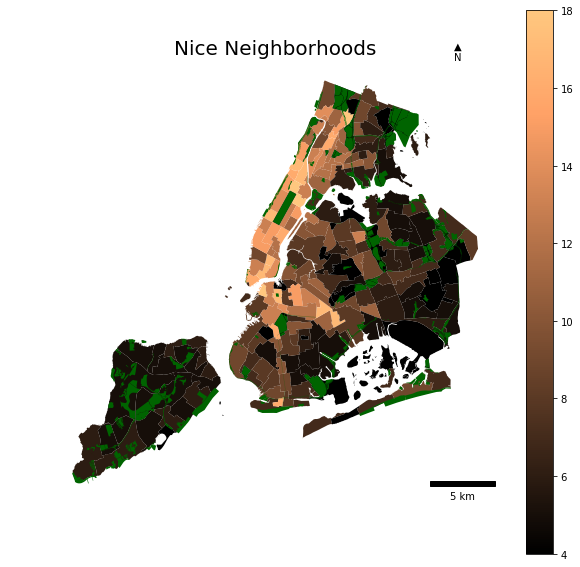

In [33]:
ax = new_nta.plot(figsize=(10,10), column='gdScr', legend=True, cmap='copper')
prk_plt.plot(ax=ax, color='#006400')

plt.title('Nice Neighborhoods', color='k', fontsize=20)
plt.axis('off')
ax.annotate(u'\u25B2 \nN', (0.9,1), xycoords='axes fraction')
scalebar = ScaleBar(0.2, color='k',frameon=False, location='lower right')
ax.add_artist(scalebar)
plt.savefig('maps/gd.pdf', bbox_inches='tight')


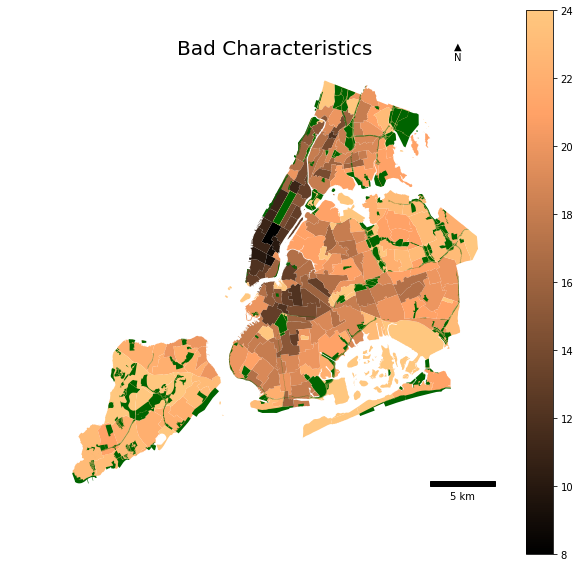

In [34]:
ax = new_nta.plot(figsize=(10,10), column='bdScr', legend=True, cmap='copper')
prk_plt.plot(ax=ax, color='#006400')

plt.title('Bad Characteristics', color='k', fontsize=20)
plt.axis('off')
ax.annotate(u'\u25B2 \nN', (0.9,1), xycoords='axes fraction')
scalebar = ScaleBar(0.2, color='k',frameon=False, location='lower right')
ax.add_artist(scalebar)
plt.savefig('maps/bd.pdf', bbox_inches='tight')


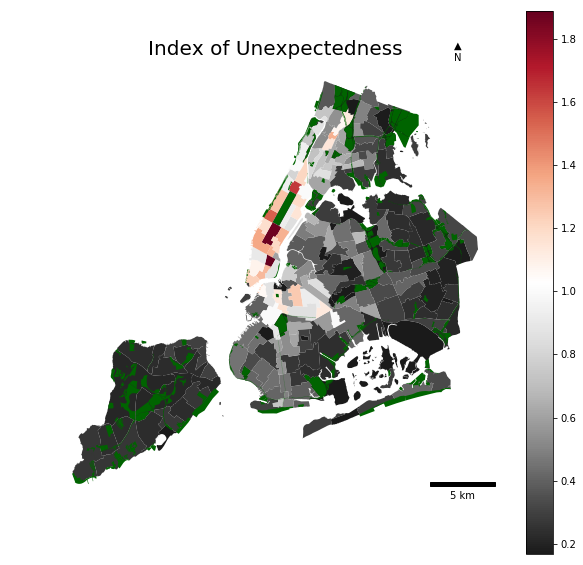

In [35]:
ax = new_nta.plot(figsize=(10,10), column='gd_bdIndx', legend=True, cmap='RdGy_r')
prk_plt.plot(ax=ax, color='#006400')

plt.title('Index of Unexpectedness', color='k', fontsize=20)
plt.axis('off')
ax.annotate(u'\u25B2 \nN', (0.9,1), xycoords='axes fraction')
scalebar = ScaleBar(0.2, color='k',frameon=False, location='lower right')
ax.add_artist(scalebar)
plt.savefig('maps/Indx.pdf', bbox_inches='tight')


Ironically, findings were as expected!   

However, there are a few noteworthy considerations that are the grains of salt these results should be taken with.  The first is that more than 1 service request can reference 1 incident, and that there is a considerable difference in the [propensity to call 311](https://arwhite.mit.edu/sites/default/files/images/White%20Trump%20-%20Promises%20Pitfalls%20311%20Data%20-%20UAR%202017.pdf) depending on the neighborhood type and the expectations of its residents.  

The second is that what was chosen to represent a 'nice neighborhood' is highly subjective, and in terms of the expectations of its residents, 'bad characteristics' vary from neighborhood to another, therefore, the variables chosen and the filters applied to 311 data are also subjective.  